# Age Classification from Face Images using CNN (UTKFace Dataset)

![Chat-GPT-Image-Jul-14-2025-01-30-29-PM.png](https://i.postimg.cc/VvmTK3mm/Chat-GPT-Image-Jul-14-2025-01-30-29-PM.png)

### Project Overview

In this notebook, I build a Convolutional Neural Network (CNN) model to classify a person's **age group** based on their face image, using the **UTKFace dataset**.

The final goal is to use this model in a **real-time webcam application**, where it predicts the age group of people detected in live video.


### Objectives

- Load and preprocess the UTKFace dataset
- Extract age labels and convert them into **age groups**
- Train a CNN model for age group classification
- Evaluate the model's performance
- (Later) Use the trained model in a real-time webcam app using OpenCV


### Why Age Classification?

Predicting age from face images is an important task in many real-world applications like:
- Smart advertising displays
- Audience analytics
- Age-based filtering in social platforms
- Personalized education and health services

This project is designed to be **beginner-friendly**, using simple models and a clear step-by-step structure.


### Dataset

The UTKFace dataset includes over 20,000 labeled face images with:
- Age (0 to 116)
- Gender
- Ethnicity

We will only use **age** in this project and group it into 5 general categories for simplicity and accuracy.

##  Data Preprocessing
Before we can train a CNN model for age classification, we need to preprocess the data. The UTKFace dataset provides facial images with age labels embedded in the filenames.

In [2]:
# Importing the tools we need
import os
import numpy as np 
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
from collections import Counter

In this step, we set the path to the UTKFace dataset folder and list all the image files it contains. This helps us:

* Confirm the dataset location

* Check the total number of images available

* Preview the first few filenames to understand the naming convention and extract useful metadata (like age, gender, and ethnicity)

In [3]:
# Set the path to the UTKFace dataset folder
folder_dir = "/kaggle/input/utkface-new/UTKFace"

# Get a list of all image filenames in the dataset folder
images_list = os.listdir(folder_dir)

print(f"Number of images: {len(images_list)}")
print(f"Type of images_list: {type(images_list)}")
print(f"First 5 filenames: {images_list[:5]}")

Number of images: 23708
Type of images_list: <class 'list'>
First 5 filenames: ['26_0_2_20170104023102422.jpg.chip.jpg', '22_1_1_20170112233644761.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg', '28_0_0_20170117180555824.jpg.chip.jpg', '17_1_4_20170103222931966.jpg.chip.jpg']


### 🔹 Extract Age from File Names
Each image filename follows a pattern like:
[age]_[gender]_[race]_[date&time].jpg

We extract the age value from the filename and store it in a new column in the dataframe. This will be used later to assign each image to an age group.

In [4]:
def extract_age_from_filenames(filenames):
    """
    Extracts age as an integer from a list of UTKFace image filenames.
    
    Each filename starts with the age (e.g., '25_1_2_...jpg').
    """
    age_list = []

    for file_name in filenames:
        parts = file_name.split("_")
        age = int(parts[0])  # Convert from string to integer
        age_list.append(age)

    return age_list

# Call the function on your image list
age_list = extract_age_from_filenames(images_list)
age_list[:10]

[26, 22, 21, 28, 17, 44, 35, 76, 36, 34]

In [5]:
# Create full image paths
image_paths = []
for name in images_list:
    image_paths.append(os.path.join("/kaggle/input/utkface-new/UTKFace", name))

print(image_paths[:5])

['/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg']


### 🔹 Group Ages into Categories
To make the task easier and more practical, we classify ages into five general groups:

* Child (0–12 years)

* Teen (13–19 years)

* Young Adult (20–35 years)

* Middle-aged (36–55 years)

* Senior (56+ years)

This transformation reduces the complexity of the problem and makes the model more robust.

In [6]:
# Create DataFrame
df = pd.DataFrame()
df["age"] = age_list
df["filename"] = images_list
df["path"] = image_paths

# Define bins and labels for age groups
bins = [0, 12, 21, 40, 60, 116]
labels = ['Child', 'Teen', 'Young Adult', 'Middle-aged', 'Senior']

# Use pd.cut to convert age to age group
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

df.head(10)

age                               filename  \
0   26  26_0_2_20170104023102422.jpg.chip.jpg   
1   22  22_1_1_20170112233644761.jpg.chip.jpg   
2   21  21_1_3_20170105003215901.jpg.chip.jpg   
3   28  28_0_0_20170117180555824.jpg.chip.jpg   
4   17  17_1_4_20170103222931966.jpg.chip.jpg   
5   44  44_0_3_20170119201022260.jpg.chip.jpg   
6   35  35_0_2_20170116182734834.jpg.chip.jpg   
7   76  76_0_0_20170104213515132.jpg.chip.jpg   
8   36  36_1_0_20170116165722892.jpg.chip.jpg   
9   34  34_0_3_20170119200815948.jpg.chip.jpg   

                                                path    age_group  
0  /kaggle/input/utkface-new/UTKFace/26_0_2_20170...  Young Adult  
1  /kaggle/input/utkface-new/UTKFace/22_1_1_20170...  Young Adult  
2  /kaggle/input/utkface-new/UTKFace/21_1_3_20170...         Teen  
3  /kaggle/input/utkface-new/UTKFace/28_0_0_20170...  Young Adult  
4  /kaggle/input/utkface-new/UTKFace/17_1_4_20170...         Teen  
5  /kaggle/input/utkface-new/UTKFace/44_0_3_20170...  Middle-aged  
6  /kaggle/input/utkface-new/UTKFace/35_0_2_20170...  Young Adult  
7  /kaggle/input/utkface-new/UTKFace/76_0_0_20170...       Senior  
8  /kaggle/input/utkface-new/UTKFace/36_1_0_20170...  Young Adult  
9  /kaggle/input/utkface-new/UTKFace/34_0_3_20170...  Young Adult

### 🔹Create Data Groups for Visualization
We group the dataset by age_group so we can visualize and analyze each group separately. This also helps identify any imbalance in the dataset that might affect model performance.

In [7]:
groups = dict(tuple(df.groupby('age_group')))
groups['Child'].head()

/tmp/ipykernel_35/4192651052.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(tuple(df.groupby('age_group')))


age                               filename  \
17   12  12_1_0_20170109203700059.jpg.chip.jpg   
22    4   4_0_0_20170110212940437.jpg.chip.jpg   
33    2   2_1_3_20161220144844310.jpg.chip.jpg   
36   10  10_1_4_20170117195152197.jpg.chip.jpg   
39    1   1_1_0_20161219154510229.jpg.chip.jpg   

                                                 path age_group  
17  /kaggle/input/utkface-new/UTKFace/12_1_0_20170...     Child  
22  /kaggle/input/utkface-new/UTKFace/4_0_0_201701...     Child  
33  /kaggle/input/utkface-new/UTKFace/2_1_3_201612...     Child  
36  /kaggle/input/utkface-new/UTKFace/10_1_4_20170...     Child  
39  /kaggle/input/utkface-new/UTKFace/1_1_0_201612...     Child

In [8]:
age_groups = df['age_group'].dropna().unique()

### 🔹 Display Random Sample Images with Age Labels
This function takes a DataFrame containing image file paths and their corresponding age labels, then:

* Randomly selects k samples from the DataFrame

* Reads and converts each image from BGR to RGB color format (since OpenCV loads images in BGR)

* Displays the selected images side by side with their age shown as the title above each image

This visualization helps us quickly understand the variety and quality of images in each age group.

In [9]:
# Function to randomly show k images from a dataframe with their age

def show_random_images(df, title, k=5):
    
    images = df.sample(n=k)

    image_paths = images['path'].tolist()
    age_labels = images['age'].tolist()

    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(title)  
    
    for i, (img_path, age) in enumerate(zip(image_paths, age_labels)):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, k, i + 1)
        plt.imshow(image)
        plt.title(f'Age: {age}')
        plt.axis('off')

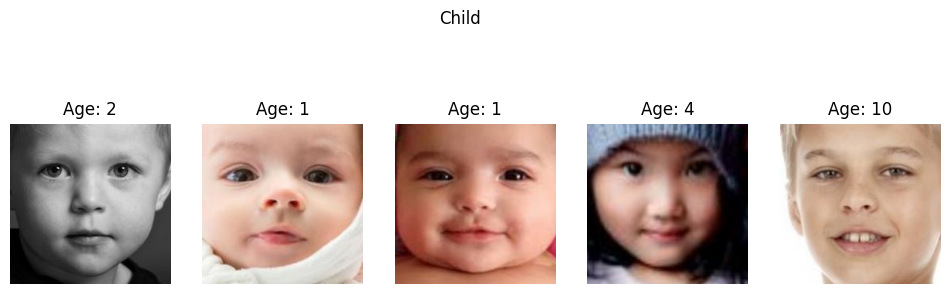

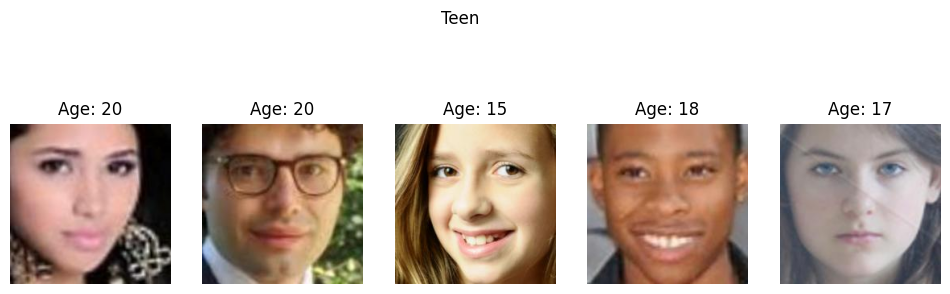

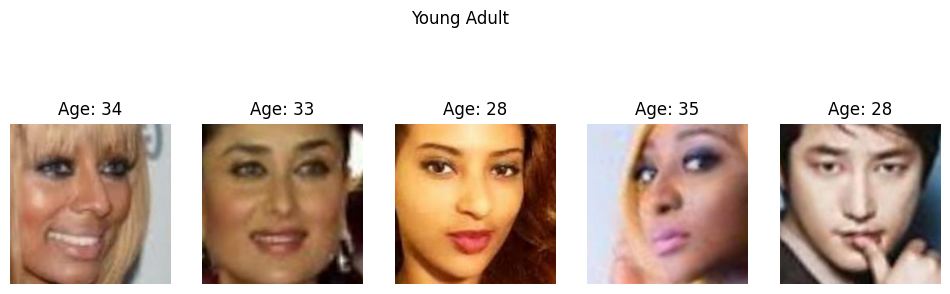

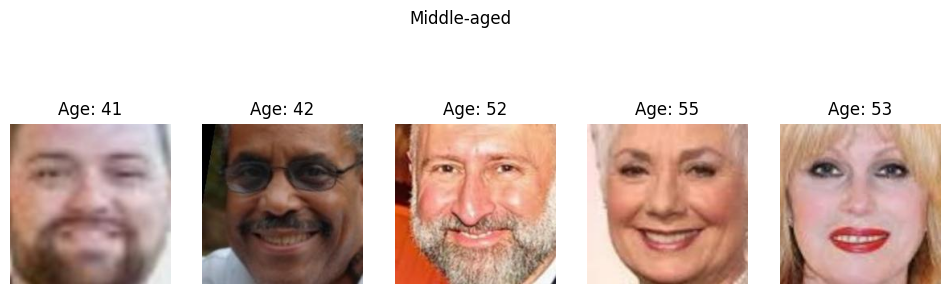

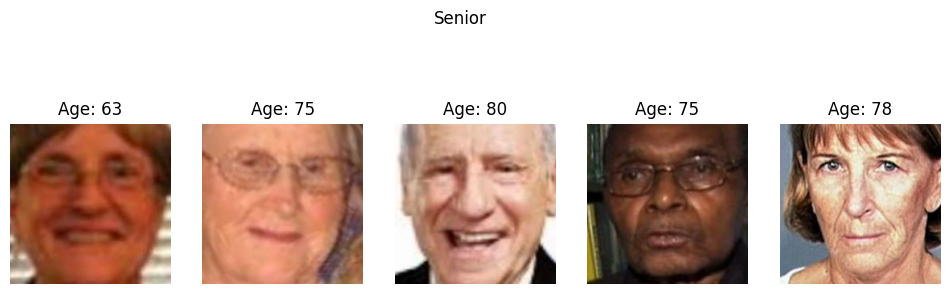

In [10]:
# Loop through each age group label and display sample images
for label in labels:
    show_random_images(groups[label], title=label)

### 🔹 Visualizing Class Distribution: Number of Images per Age Group
This plot shows the number of images available in each age group category.
By examining this bar chart, we can identify any class imbalance in the dataset — which is important because uneven class sizes can affect model training and performance.

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


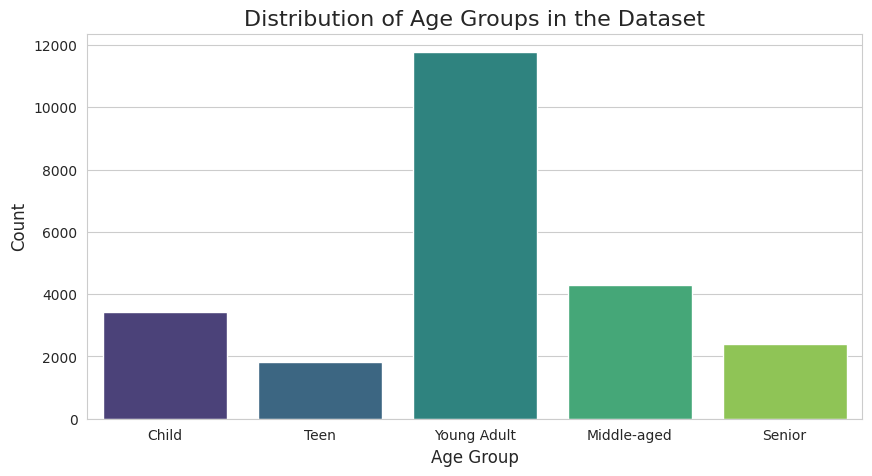

Value counts for each age group:
age_group
Young Adult    11777
Middle-aged     4311
Child           3413
Senior          2397
Teen            1810
Name: count, dtype: int64


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style('whitegrid')

# Visualize the distribution of age groups
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='age_group', order=labels, palette='viridis')
plt.title('Distribution of Age Groups in the Dataset', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Print the exact counts
print("Value counts for each age group:")
print(df['age_group'].value_counts())

## Dataset Splitting and Image Data Preparation

To streamline the training process and ensure efficient memory usage, we utilized TensorFlow’s `ImageDataGenerator` for preprocessing and loading images in batches. This approach allows us to:

- Normalize pixel values (scaling images to range [0, 1])
- Apply real-time data augmentation (optional, to improve generalization)
- Automatically label images based on age group
- Split the dataset into training, validation, and test sets in a structured way

After configuring the generators, we obtained the following distribution:
- **Training Set:** 18,966 images
- **Validation Set:** 2,371 images
- **Test Set:** 2,371 images  
These were automatically categorized into 5 age groups: `Child`, `Teen`, `Young Adult`, `Middle-aged`, and `Senior`.

This setup ensures balanced learning and helps prevent overfitting while reducing memory overhead.

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMG_SIZE = 128  # A smaller size like 128x128 is efficient
BATCH_SIZE = 64 # The number of images to process in each batch

2025-07-21 14:12:38.612354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753107158.859932      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753107158.922591      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
# We need to split the data three ways. First, split into training (80%) and testing (20%).
# We use 'stratify' to ensure the proportion of age groups is the same in both sets.
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['age_group']
)

# Now, split the training set again to create a validation set (20% of the original 80%).
train_df, val_df = train_test_split(
    train_df,
    test_size=0.25, # 0.25 * 0.80 = 0.20 of the original data
    random_state=42,
    stratify=train_df['age_group']
)

print(f"Total images: {len(df)}")
print(f"Training images: {len(train_df)}")
print(f"Validation images: {len(val_df)}")
print(f"Test images: {len(test_df)}")

Total images: 23708
Training images: 14224
Validation images: 4742
Test images: 4742


In [14]:
# Create a data generator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    rotation_range=20,       # Randomly rotate images
    width_shift_range=0.2,   # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'
)

# Create a data generator for validation and testing (only rescaling)
# We don't augment validation/test data to get a true measure of performance.
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
## Create generators that will read images from our DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='age_group',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # for multi-class classification
    shuffle=True
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='age_group',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # No need to shuffle validation data
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='age_group',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # No need to shuffle test data
)

Found 14224 validated image filenames belonging to 5 classes.
Found 4742 validated image filenames belonging to 5 classes.
Found 4742 validated image filenames belonging to 5 classes.


## Phase 1: Training the Classification Head

Now that our data is prepared and our model architecture is defined, we can begin the first phase of training.

**Our Strategy: Transfer Learning (Feature Extraction)**

In this initial phase, we will follow a specific strategy:

1.  **Freeze the Base Model:** We will keep all the layers of the pre-trained `MobileNetV2` model "frozen." This means their weights will **not** be updated during training. We are essentially using this powerful, pre-trained network as a fixed feature extractor.
2.  **Train Only the Head:** We will only train the new, custom layers we added on top (the `GlobalAveragePooling2D`, `Dense`, and `Dropout` layers). This "head" will learn how to take the sophisticated features extracted by `MobileNetV2` and map them to our five age group classes.

**Key Components of the Training Process:**

*   **`class_weight`**: We are providing class weights to the `.fit()` method. This tells the model to pay more attention to the under-represented classes (like 'Child' and 'Senior'), helping to counteract the data imbalance we observed earlier.
*   **`ModelCheckpoint`**: This callback will monitor the `val_accuracy` after each epoch and save the model weights only when the accuracy on the validation set improves. This ensures we always keep the best version of our model.
*   **`EarlyStopping`**: To prevent overfitting and save time, this callback will stop the training process automatically if the `val_accuracy` does not improve for a set number of epochs (our "patience"). It will also restore the best weights found during the run.

Let's start the training process!

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

In [17]:
# Load the MobileNetV2 model, pre-trained on ImageNet, without the top classification layer
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False, # We are providing our own top layer
    weights='imagenet'
)

# Freeze the layers of the base model so they are not trained
base_model.trainable = False

I0000 00:00:1753107205.434464      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753107205.435363      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Add our custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces spatial dimensions to a single vector
x = Dense(1024, activation='relu')(x) # A fully-connected layer for learning
x = Dropout(0.5)(x) # Dropout to prevent overfitting
# The final output layer has 5 neurons (for our 5 age groups) and a softmax activation
predictions = Dense(len(labels), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,574,853 (13.64 MB)

 Trainable params: 1,316,869 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to handle data imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.3897410845139229, 1: 1.0996521066872826, 2: 1.9783031988873436, 3: 2.619521178637201, 4: 0.40260401924709877}


In [21]:
# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5', # Filepath to save the model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5, # Stop after 5 epochs of no improvement
    restore_best_weights=True
)

In [22]:
# Train the model
history = model.fit(
    train_generator,
    epochs=25, # Set a higher number of epochs; EarlyStopping will handle the rest
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1753107218.971705     101 service.cc:148] XLA service 0x7ad3880055e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753107218.972679     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753107218.972706     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753107219.990361     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/223 ━━━━━━━━━━━━━━━━━━━━ 55:51 15s/step - accuracy: 0.1094 - loss: 2.1752

I0000 00:00:1753107224.658668     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


223/223 ━━━━━━━━━━━━━━━━━━━━ 165s 676ms/step - accuracy: 0.4000 - loss: 1.4506 - val_accuracy: 0.5352 - val_loss: 1.0709
Epoch 2/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 84s 377ms/step - accuracy: 0.4891 - loss: 1.0719 - val_accuracy: 0.4895 - val_loss: 1.1103
Epoch 3/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 86s 385ms/step - accuracy: 0.5074 - loss: 1.0212 - val_accuracy: 0.5822 - val_loss: 0.9810
Epoch 4/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 85s 382ms/step - accuracy: 0.5250 - loss: 1.0044 - val_accuracy: 0.5487 - val_loss: 1.0138
Epoch 5/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 84s 375ms/step - accuracy: 0.5212 - loss: 0.9944 - val_accuracy: 0.4623 - val_loss: 1.1180
Epoch 6/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 85s 381ms/step - accuracy: 0.5230 - loss: 0.9935 - val_accuracy: 0.4308 - val_loss: 1.1817
Epoch 7/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 85s 379ms/step - accuracy: 0.5246 - loss: 0.9668 - val_accuracy: 0.5877 - val_loss: 0.9901
Epoch 8/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 84s 377ms/step - accuracy: 0.5216 - loss: 0.9825 - va

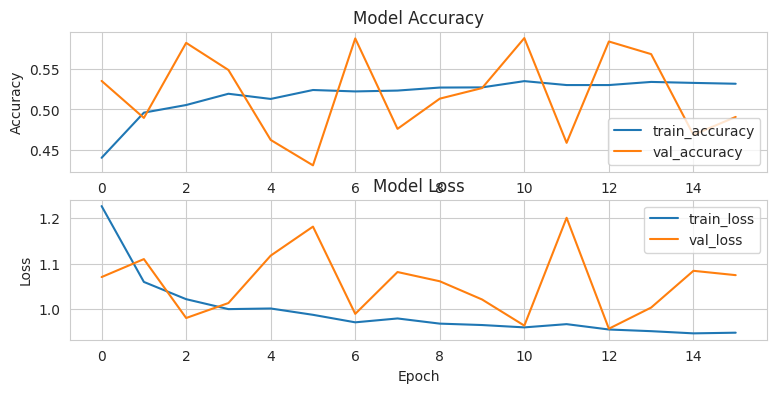


Evaluating on the test set...
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 318ms/step - accuracy: 0.5860 - loss: 0.9590
Test Loss: 0.9581
Test Accuracy: 0.5863


In [23]:
# Plot training & validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 4))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='train_accuracy')
ax1.plot(history.history['val_accuracy'], label='val_accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plot loss
ax2.plot(history.history['loss'], label='train_loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')

plt.show()

# Final evaluation on the test set
print("\nEvaluating on the test set...")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step


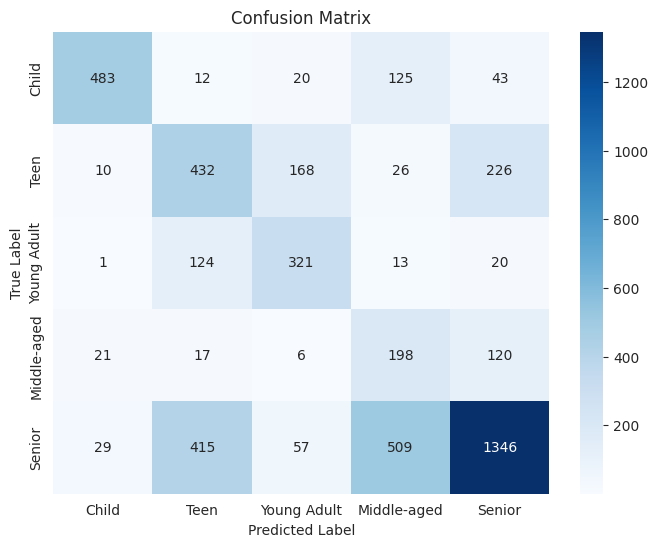


Classification Report:
              precision    recall  f1-score   support

       Child       0.89      0.71      0.79       683
        Teen       0.43      0.50      0.46       862
 Young Adult       0.56      0.67      0.61       479
 Middle-aged       0.23      0.55      0.32       362
      Senior       0.77      0.57      0.65      2356

    accuracy                           0.59      4742
   macro avg       0.58      0.60      0.57      4742
weighted avg       0.66      0.59      0.61      4742



In [24]:
from sklearn.metrics import classification_report, confusion_matrix

# Get model predictions on the test set
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Generate a confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

## Phase 2: Fine-Tuning the Model for Higher Accuracy

Our initial model was trained with the `MobileNetV2` base completely frozen. This was like using a powerful, general-purpose feature extractor. The model achieved a respectable baseline accuracy of around 61%.

Now, for the key to unlocking higher performance: **fine-tuning**.

**What is Fine-Tuning?**
1.  We will **unfreeze** the top layers of the pre-trained `MobileNetV2` model.
2.  We will continue training the **entire model** (our custom head + the unfrozen base layers) with a **very low learning rate**.

**Why do this?**
This allows the model to make small, precise adjustments to its powerful, pre-trained feature detectors, adapting them specifically for the nuances of our face-age dataset. The low learning rate is crucial to prevent the model from "forgetting" all the valuable knowledge it learned from ImageNet.

We will start fine-tuning from where our previous training left off. Let's see how much this improves our performance!

In [25]:
# First, let's load the best weights we saved from the initial training phase.
# This ensures we are starting from the best possible point.
model.load_weights('best_model.h5')

# Unfreeze the base model. Now, all layers can be trained.
base_model.trainable = True

# Let's see how many layers are in the base model
print(f"Number of layers in the base model: {len(base_model.layers)}")

Number of layers in the base model: 154


In [26]:
# We will fine-tune from layer 100 onwards. The early layers of a CNN learn
# very general features (like edges and colors), which we want to keep.
# The later layers learn more complex, specific features (like eye shapes or wrinkles),
# which are the ones we want to adapt.
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model with a very low learning rate for fine-tuning.
# A low learning rate (e.g., 1e-5 or 0.00001) is CRUCIAL for successful fine-tuning.
# It prevents catastrophic forgetting where the model's powerful pre-trained weights are destroyed.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary to see the new number of trainable parameters
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,574,853 (13.64 MB)

 Trainable params: 3,178,309 (12.12 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [27]:
fine_tune_epochs = 20 # We can fine-tune for another 10 epochs
total_epochs = history.epoch[-1] + 1 + fine_tune_epochs # e.g., if initial training stopped at epoch 9, this will be 10 + 10 = 20

In [ ]:
# We can reuse our callbacks. The ModelCheckpoint will continue to save the best model.
history_fine_tune = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1, # Start from the epoch number where we left off
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stopping]
)

Epoch 17/36
223/223 ━━━━━━━━━━━━━━━━━━━━ 87s 392ms/step - accuracy: 0.6012 - loss: 0.8014 - val_accuracy: 0.6019 - val_loss: 0.8743
Epoch 18/36
223/223 ━━━━━━━━━━━━━━━━━━━━ 87s 389ms/step - accuracy: 0.6094 - loss: 0.7663 - val_accuracy: 0.6057 - val_loss: 0.8714
Epoch 19/36
223/223 ━━━━━━━━━━━━━━━━━━━━ 86s 386ms/step - accuracy: 0.6032 - loss: 0.7671 - val_accuracy: 0.6208 - val_loss: 0.8629
Epoch 20/36
223/223 ━━━━━━━━━━━━━━━━━━━━ 87s 390ms/step - accuracy: 0.6113 - loss: 0.7699 - val_accuracy: 0.6094 - val_loss: 0.8661
Epoch 21/36
223/223 ━━━━━━━━━━━━━━━━━━━━ 112s 502ms/step - accuracy: 0.6190 - loss: 0.7437 - val_accuracy: 0.6092 - val_loss: 0.8709
Epoch 22/36
223/223 ━━━━━━━━━━━━━━━━━━━━ 124s 553ms/step - accuracy: 0.6179 - loss: 0.7550 - val_accuracy: 0.6042 - val_loss: 0.8673
Epoch 23/36
223/223 ━━━━━━━━━━━━━━━━━━━━ 90s 404ms/step - accuracy: 0.6273 - loss: 0.7161 - val_accuracy: 0.6025 - val_loss: 0.8687
Epoch 24/36
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6285 

In [32]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Fine-Tuned Test Loss: {test_loss:.4f}")
print(f"Fine-Tuned Test Accuracy: {test_accuracy:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.6187 - loss: 0.8447
Fine-Tuned Test Loss: 0.8435
Fine-Tuned Test Accuracy: 0.6238


In [33]:
# Let's see the detailed classification report again
print("\n--- Fine-Tuned Classification Report ---")
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=labels))


--- Fine-Tuned Classification Report ---
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step
              precision    recall  f1-score   support

       Child       0.90      0.83      0.86       683
        Teen       0.44      0.63      0.52       862
 Young Adult       0.63      0.72      0.67       479
 Middle-aged       0.26      0.54      0.35       362
      Senior       0.82      0.56      0.66      2356

    accuracy                           0.62      4742
   macro avg       0.61      0.66      0.61      4742
weighted avg       0.70      0.62      0.64      4742



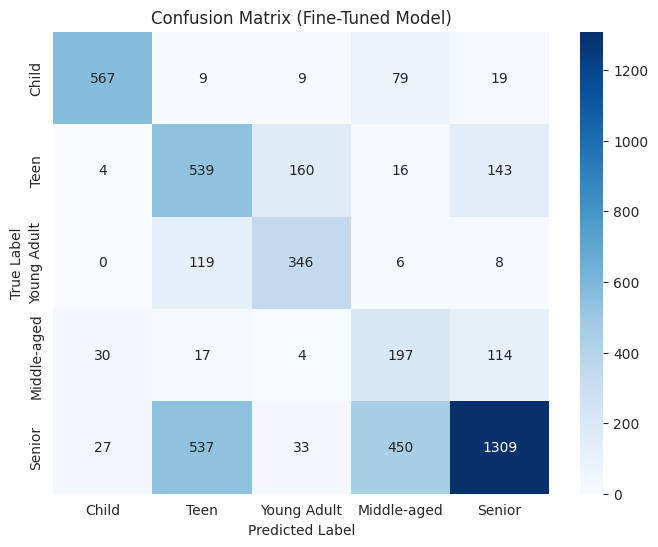

In [34]:
# And the new confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Fine-Tuned Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [35]:
model.save('/kaggle/working/age_classifier_model_2.h5')

## Evaluation and Visualization of the Age Group Classifier

In this section, we evaluated a fine-tuned deep learning model trained to classify images into age groups. After loading the model, predictions were made on a test dataset, and both predicted and true labels were extracted. To better understand the model’s performance, we visualized 50 randomly selected test images, showing their true and predicted labels along with prediction confidence. Correct predictions were marked in green and incorrect ones in red, making visual error analysis easy and intuitive. Finally, the model's performance was quantitatively assessed using standard evaluation metrics, reporting the final test loss and accuracy. This process provided both a numerical and visual understanding of how well the model generalizes to unseen data.


In [36]:
from tensorflow.keras.models import load_model

age_group_classifier = load_model('/kaggle/input/age_group_classifier/tensorflow2/default/1/age_classifier_model_2.h5')

In [37]:
age_group_classifier.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,574,855 (13.64 MB)

 Trainable params: 3,178,309 (12.12 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 2 (12.00 B)

In [38]:
# Make predictions
pred_probs = age_group_classifier.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_ture = test_generator.classes

75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step


In [39]:
y_pred[:10], y_ture[:10]

(array([4, 3, 0, 0, 1, 4, 0, 2, 2, 3]), [4, 1, 0, 0, 1, 4, 0, 2, 2, 4])

In [40]:
# Filepaths and label mapping
file_paths = test_generator.filepaths
labels = list(test_generator.class_indices.keys()) # class indices are in the generator

print(file_paths[:5])
print(labels[:5])


# Convert true and predicted indices to names

y_ture_labels = [labels[i] for i in y_ture]
y_pred_labels = [labels[i] for i in y_pred]

['/kaggle/input/utkface-new/UTKFace/32_1_2_20170116191616216.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/43_1_1_20170116003503143.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/1_1_0_20170109192015845.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/1_1_3_20161219225245716.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/55_0_3_20170119191938385.jpg.chip.jpg']
['Child', 'Middle-aged', 'Senior', 'Teen', 'Young Adult']


In [41]:
y_pred_labels[:10], y_ture_labels[:10]

(['Young Adult',
  'Teen',
  'Child',
  'Child',
  'Middle-aged',
  'Young Adult',
  'Child',
  'Senior',
  'Senior',
  'Teen'],
 ['Young Adult',
  'Middle-aged',
  'Child',
  'Child',
  'Middle-aged',
  'Young Adult',
  'Child',
  'Senior',
  'Senior',
  'Young Adult'])

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step


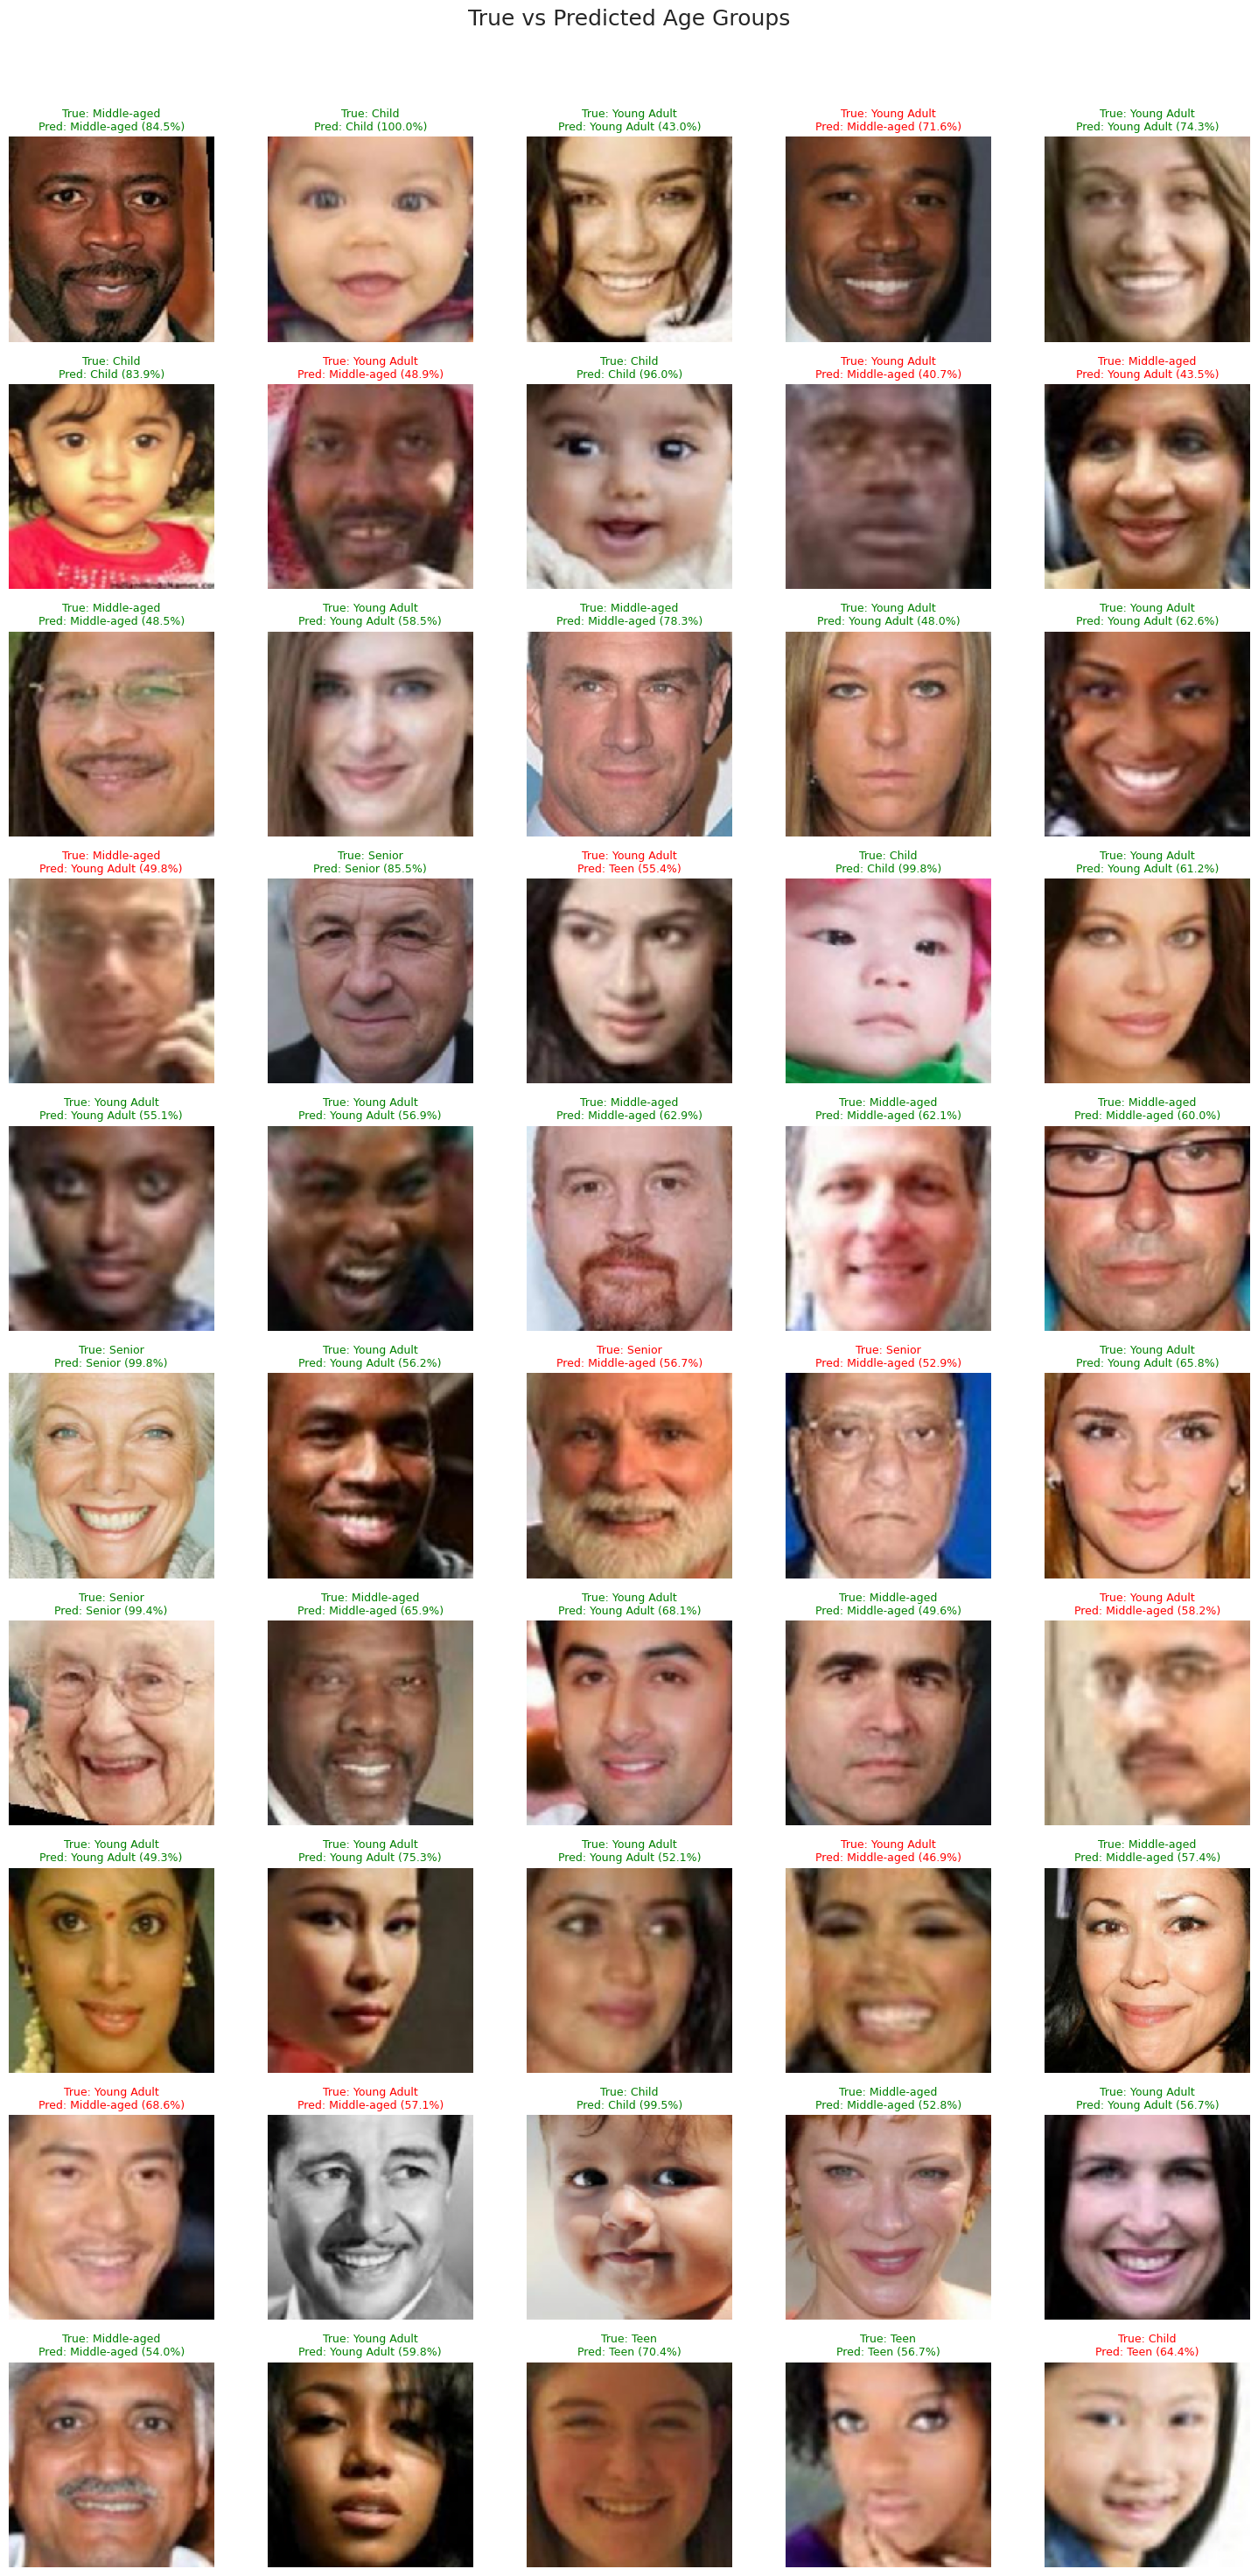

In [42]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random
import numpy as np

# Define rows and columns
rows = 10
cols = 5
num_images = rows * cols

# Use a new name for all prediction probabilities
all_pred_probs = age_group_classifier.predict(test_generator)

# Create the figure
fig, axes = plt.subplots(rows, cols, figsize=(15, 30))
fig.suptitle("True vs Predicted Age Groups", fontsize=18)

# Sample image indices
sample_indices = random.sample(range(len(file_paths)), num_images)

# Loop through and plot each image
for idx, ax in zip(sample_indices, axes.flatten()):
    img_path = file_paths[idx]
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0

    true_label = y_ture_labels[idx]
    pred_label = y_pred_labels[idx]

    # ✅ Get the prediction vector for this sample
    pred_probs = all_pred_probs[idx]
    confidence = np.max(pred_probs) * 100

    color = 'green' if true_label == pred_label else 'red'

    ax.imshow(img_array)
    ax.axis('off')
    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)",
                 fontsize=9, color=color)

# Tidy up layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [43]:
test_loss, test_accuracy = age_group_classifier.evaluate(test_generator)
print(f"Fine-Tuned Test Loss: {test_loss:.4f}")
print(f"Fine-Tuned Test Accuracy: {test_accuracy:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.6250 - loss: 0.8394
Fine-Tuned Test Loss: 0.8376
Fine-Tuned Test Accuracy: 0.6246
